# How to Develop a Face Recognition System Using FaceNet in Keras

https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

In this tutorial, you will discover how to develop a face detection system using FaceNet and an SVM classifier to identify people from photographs.

After completing this tutorial, you will know:

* About the FaceNet face recognition system developed by Google and open source implementations and pre-trained models.
* How to prepare a face detection dataset including first extracting faces via a face detection system and then extracting face features via face embeddings.
* How to fit, evaluate, and demonstrate an SVM model to predict identities from faces embeddings.


## FaceNet Model for face embedding

It is a system that, given a picture of a face, will extract high-quality features from the face and predict a 128 element vector representation these features, called a **face embedding**.

The model is a deep convolutional neural network trained via a triplet loss function that encourages vectors for the same identity to become more similar (smaller distance), whereas vectors for different identities are expected to become less similar (larger distance).

We will use the **pre-trained Keras FaceNet model** provided by Hiroki Taniai in this tutorial. It was trained on **MS-Celeb-1M dataset** and expects input images to be color, to have their pixel values whitened (standardized across all three channels), and to have a square shape of 160×160 pixels.

In [3]:
from keras.models import load_model

# load the model
model = load_model('/content/drive/MyDrive/Face Recognition in Keras/facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


The model will be trained and tested using the ‘5 Celebrity Faces Dataset‘ that contains many photographs of five different celebrities.

We will use an **MTCNN** model for **face detection**, the **FaceNet** model will be used to create a **face embedding** for each detected face, then we will develop a **Linear SVM** classifier model to predict the identity of a given face.

##Detect and extract Faces from images(MTCNN)

Before we can perform face recognition, we need to detect faces.

In this tutorial, we will also use the Multi-Task Cascaded Convolutional Neural Network, or MTCNN, for face detection, e.g. finding and extracting faces from photos.

In [2]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 11.6MB/s 


In [ ]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

In [4]:
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import asarray, savez_compressed, load
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

In [13]:
image = Image.open('/content/drive/MyDrive/Face Recognition in Keras/match/Me.jpg')
image = image.convert('RGB')
# convert to array
asarray(image)

array([[[233, 238, 241],
        [234, 239, 242],
        [234, 239, 242],
        ...,
        [252, 254, 249],
        [252, 254, 249],
        [252, 254, 249]],

       [[232, 237, 240],
        [233, 238, 241],
        [234, 239, 242],
        ...,
        [252, 254, 249],
        [252, 254, 249],
        [252, 254, 249]],

       [[232, 237, 240],
        [233, 238, 241],
        [233, 238, 241],
        ...,
        [252, 254, 249],
        [252, 254, 249],
        [252, 254, 249]],

       ...,

       [[232, 232, 240],
        [230, 230, 238],
        [228, 228, 236],
        ...,
        [235, 238, 245],
        [236, 239, 246],
        [239, 242, 249]],

       [[231, 231, 239],
        [230, 230, 238],
        [227, 227, 235],
        ...,
        [234, 237, 244],
        [236, 239, 246],
        [237, 240, 245]],

       [[228, 228, 236],
        [228, 228, 236],
        [226, 226, 234],
        ...,
        [234, 237, 244],
        [236, 239, 244],
        [236, 239, 244]]

In [10]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix(Sometimes the library will return a negative pixel index)
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# load the photo and extract the face
pixels = extract_face('/content/drive/MyDrive/Face Recognition in Keras/match/Me.jpg')

In [7]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
  
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [9]:
'''
# load train dataset
trainX, trainy = load_dataset('/content/drive/MyDrive/Face Recognition in Keras/data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/drive/MyDrive/Face Recognition in Keras/data/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('/content/drive/MyDrive/Face Recognition in Keras/data/5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)
'''

"\n# load train dataset\ntrainX, trainy = load_dataset('/content/drive/MyDrive/Face Recognition in Keras/data/train/')\nprint(trainX.shape, trainy.shape)\n# load test dataset\ntestX, testy = load_dataset('/content/drive/MyDrive/Face Recognition in Keras/data/val/')\nprint(testX.shape, testy.shape)\n# save arrays to one file in compressed format\nsavez_compressed('/content/drive/MyDrive/Face Recognition in Keras/data/5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)\n"

## Create Face Embeddings

In [1]:
from numpy import load, expand_dims, asarray, savez_compressed
from keras.models import load_model

# load dataset
data = load('/content/drive/MyDrive/Face Recognition in Keras/data/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


We can then enumerate each face in the train and test datasets to predict an embedding.

In [12]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [ ]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('/content/drive/MyDrive/Face Recognition in Keras/data/5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

## Perform Face Classification

In [4]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

# load dataset
data = load('/content/drive/MyDrive/Face Recognition in Keras/data/5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


In [5]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)

# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


##The Face Recognition System Starts From Here

We can make it more interesting by plotting the original face and the prediction. 

First, we need to select a random example from the test set, then get the embedding, face pixels, expected class prediction, and the corresponding name for the class.

Predicted: mindy_kaling (91.547)
Expected: mindy_kaling


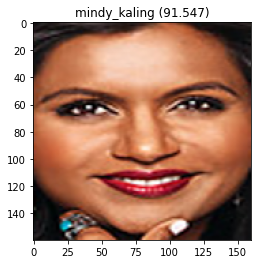

In [14]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load, expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

# load faces
data = load('/content/drive/MyDrive/Face Recognition in Keras/data/5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']

# load face embeddings
data = load('/content/drive/MyDrive/Face Recognition in Keras/data/5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

### face matching

In [40]:
from os import listdir

def face_matching(image_file, model):
  facenet = load_model('/content/drive/MyDrive/Face Recognition in Keras/facenet_keras.h5')
  face = extract_face(image_file)
  face_emb = get_embedding(facenet, face)

  # prediction for the face
  samples = expand_dims(face_emb, axis=0)
  yhat_class = model.predict(samples)
  yhat_prob = model.predict_proba(samples)

  # get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  predict_names = out_encoder.inverse_transform(yhat_class)
  print('Predicted: {0:} {1:.3f}%'.format(predict_names[0], class_probability))
  
  path = listdir('/content/drive/MyDrive/Face Recognition in Keras/data/val/'+predict_names[0])
  cele_face = extract_face('/content/drive/MyDrive/Face Recognition in Keras/data/val/'+predict_names[0]+'/'+path[0])

  # plot for fun
  pyplot.subplot(1,2,1)
  pyplot.imshow(face)
  title = 'Your face image'
  pyplot.title(title)
  pyplot.subplot(1,2,2)
  pyplot.imshow(cele_face)
  title = '{0:} {1:.3f}%'.format(predict_names[0], class_probability)
  pyplot.title(title)
  pyplot.show()

Predicted: elton_john 94.504%


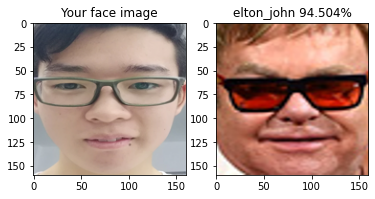

Predicted: mindy_kaling 100.000%


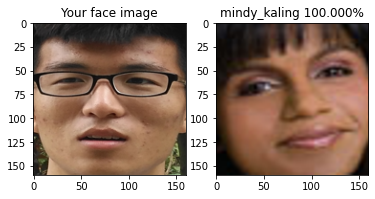

Predicted: ben_afflek 52.040%


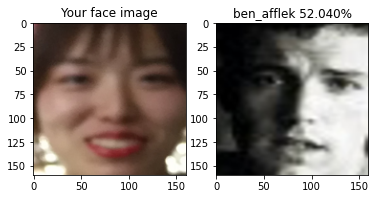

Predicted: elton_john 76.965%


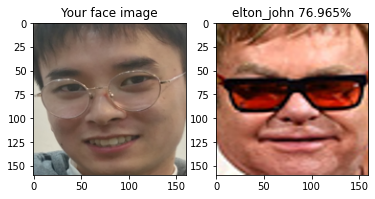

In [49]:
face_matching('/content/drive/MyDrive/Face Recognition in Keras/match/Me.jpg', model)
face_matching('/content/drive/MyDrive/Face Recognition in Keras/match/CaoJiuQ.jpg', model)
face_matching('/content/drive/MyDrive/Face Recognition in Keras/match/XiaoYue.jpg', model)
face_matching('/content/drive/MyDrive/Face Recognition in Keras/match/BaoBao.jpg', model)